In [68]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii
from itertools import repeat

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6
tournament_number = 20

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [96]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')
prompt_dates['Data']

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
624   2023-06-20
625   2023-06-21
626   2023-06-22
627   2023-06-23
628   2023-06-24
Name: Data, Length: 629, dtype: datetime64[ns]

## Ruch - dni

In [8]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,7.00,3.800
1,2021-06-02,Środa,6.01,7.01,3.404
2,2021-06-04,Piątek,11.02,13.02,4.408
3,2021-06-05,Sobota,11.03,11.03,4.412
4,2021-06-07,Poniedziałek,8.04,6.04,3.216


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

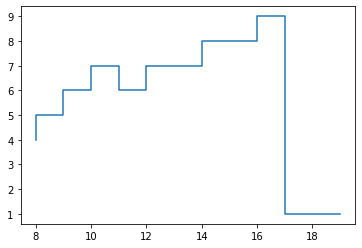

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

0.9999999999999999

## Gry

In [97]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [98]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,Zakazana wyspa,inna,przygodowa,Zakazana Wyspa to kooperacyjna gra przygodowa ...,NIE,74.96,NaN,NaN
2,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5
3,Dixit Odyseja,karciana,towarzyska,"Dixit to narracyjna gra karciana, w której wym...",TAK,99.90,15.0,8
4,Story Cubes,planszowa,narracyjna,Oto prosta w założeniach i jednocześnie genial...,NIE,45.88,5.0,NaN


In [99]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [102]:
prompt_games.reindex(labels=['game_id','Nazwa', 'rodzaj', 'kategoria', 'opis', 'Turniej', 'Kupno', 'Wypożyczenie', 'Liczba uczestników', 'wagi'], axis=1)
game_id = [*id_generator(len(prompt_games['Nazwa']))]
prompt_games.insert(0, 'game_id', game_id)

ValueError: cannot insert game_id, already exists

In [103]:
prompt_games

,game_id,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,1,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,2,Zakazana wyspa,inna,przygodowa,Zakazana Wyspa to kooperacyjna gra przygodowa ...,NIE,74.96,NaN,NaN,0.044128
2,3,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5,0.042363
3,4,Dixit Odyseja,karciana,towarzyska,"Dixit to narracyjna gra karciana, w której wym...",TAK,99.90,15.0,8,0.040669
4,5,Story Cubes,planszowa,narracyjna,Oto prosta w założeniach i jednocześnie genial...,NIE,45.88,5.0,NaN,0.039043
5,6,Ubongo,planszowa,familijna,Szalona gra która rozkręci Twój mózg! Ubongo t...,NIE,81.46,NaN,NaN,0.037481
6,7,Podaj Łapę,karciana,familijna,Gracze zostają wolontariuszami schroniska i po...,NIE,136.44,9.0,NaN,0.035982
7,8,Super Farmer,inna,familijna,Super Farmer to kultowa gra rodzinna o strateg...,TAK,34.00,5.0,4,0.034543
8,9,Mrówki,karciana,familijna,Twoim zadaniem jest odnajdywanie małych mrówek...,NIE,25.97,NaN,NaN,0.033161
9,10,Wsiąść do Pociągu: Europa,planszowa,familijna,Wsiąść do Pociągu: Europa to gra familijna o w...,TAK,141.90,20.0,5,0.031835


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [22]:
id_generator = lambda n: [*range(1, n+1)]


gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [23]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'staff_id': [*id_generator(n)],
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [24]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
0,1,AMELIA,KRAWCZYK,664078777,AMELIA.KRAWCZYK@wp.pl,Wrocław,3856.70,True,F,2021-06-01,NaN,2021-06-01 09:29:46
1,2,PRZEMYSŁAW,MICHAŁOWSKI,534711880,PRZEMYSLAW.MICHALOWSKI@gmail.com,Wrocław,3739.73,False,M,2021-06-01,NaN,2021-06-01 09:29:46
2,3,KAROLINA,PILARSKA,724158493,KAROLINA.PILARSKA@outlook.com,Wrocław,3731.96,False,F,2021-06-01,NaN,2021-06-01 09:29:46
3,4,HANNA,SŁAWIŃSKA,692906632,HANNA.SLAWINSKA@onet.pl,Wrocław,3599.66,False,F,2021-06-01,NaN,2021-06-01 09:29:46
4,5,DANIEL,SIENKIEWICZ,664661405,DANIEL.SIENKIEWICZ@chello.pl,Wrocław,NaN,False,M,2021-06-01,2022-11-27,2022-11-27 09:29:46
5,6,MAŁGORZATA,DZIUBEK,720939515,MALGORZATA.DZIUBEK@polska.pl,Wrocław,3585.06,False,F,2022-12-27,NaN,2022-12-27 09:29:46


## Godziny pracy

In [25]:
hours = range(8,20)
weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']
workers = staff.staff_id
w = []
h = []
for i in range(8,20):
    for j in weekdays:
        w.append(j)
        h.append(i)
wk = []
for i in h:
    if i < 14:
        wk.append((1,2))
    else:
        wk.append((3,4,6))
        
weekday_hour_worker = pd.DataFrame({
    'weekdays': w, 
    'hour': h, 
    'staff': wk
})

In [26]:
weekday_hour_worker

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"
...,...,...,...
67,Wtorek,19,"(3, 4, 6)"
68,Środa,19,"(3, 4, 6)"
69,Czwartek,19,"(3, 4, 6)"
70,Piątek,19,"(3, 4, 6)"


## Związki

In [27]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [28]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_time_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = [*range(1, n+1)]
    df['partner_id'] = [*range(1, n+1)]
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [29]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
7,1,2,M,1,5,2021-10-29 02:53:09
8,2,4,F,2,6,2021-11-09 10:34:57
6,3,2,M,3,3,2021-12-05 01:54:09
1,4,4,F,4,6,2021-12-05 19:48:54
5,5,4,F,5,3,2021-12-15 13:54:45
2,6,3,F,6,5,2022-11-03 14:48:15
0,7,2,M,7,4,2023-01-21 00:31:56
3,8,6,F,8,4,2023-05-06 13:37:56
4,9,3,F,9,6,2023-05-19 17:05:03


## Partnerzy

In [30]:
def partners_df_generator(relationships_df):
    n = relationships_df.shape[0]
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [31]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
7,1,MARIA,F,2021-10-29 02:53:09
8,2,AGNIESZKA,F,2021-11-09 10:34:57
6,3,ANNA,F,2021-12-05 01:54:09
1,4,ROBERT,M,2021-12-05 19:48:54
5,5,MONIKA,F,2021-12-15 13:54:45
2,6,SZYMON,M,2022-11-03 14:48:15
0,7,MARIA,F,2023-01-21 00:31:56
3,8,JAKUB,M,2023-05-06 13:37:56
4,9,SZYMON,M,2023-05-19 17:05:03


## Klienci - część A

In [32]:
customers = pd.DataFrame({'customer_id': [i for i in range(1,1501)]})

## Koszty utrzymania

In [33]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [34]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'czynsz ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'czynsz')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'energia elektryczna ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'woda ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ogrzewanie ' + str(x).lower())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'media')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'pensja')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = [*range(1, df.shape[0]+1)]
    df['invoice_id'] = [*range(1, df.shape[0]+1)]
    df['spend_id'] = [*range(1, df.shape[0]+1)]
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [35]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,energia elektryczna czerwiec,152.50,media,2021-06-05,1,1,2021-06-05 14:54:28
3,2,woda czerwiec,47.63,media,2021-06-05,2,2,2021-06-05 17:26:12
3,3,czynsz czerwiec,3250.00,czynsz,2021-06-05,3,3,2021-06-05 17:29:35
0,4,PENSJA CZERWIEC AMELIA KRAWCZYK,3856.70,pensja,2021-06-10,4,4,2021-06-10 10:30:30
2,5,PENSJA CZERWIEC KAROLINA PILARSKA,3731.96,pensja,2021-06-10,5,5,2021-06-10 10:38:23
...,...,...,...,...,...,...,...,...
146,206,PENSJA CZERWIEC KAROLINA PILARSKA,3731.96,pensja,2023-06-10,206,206,2023-06-10 09:06:44
145,207,PENSJA CZERWIEC PRZEMYSŁAW MICHAŁOWSKI,3739.73,pensja,2023-06-10,207,207,2023-06-10 09:28:01
144,208,PENSJA CZERWIEC AMELIA KRAWCZYK,3856.70,pensja,2023-06-10,208,208,2023-06-10 11:08:48
147,209,PENSJA CZERWIEC HANNA SŁAWIŃSKA,3599.66,pensja,2023-06-10,209,209,2023-06-10 11:09:41


## Typy wydatków

In [36]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df['expenses_type_id'] = [*range(1, df.shape[0]+1)]
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [37]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,media,2023-06-05 10:24:44
612,2,czynsz,2023-06-05 15:22:08
149,3,pensja,2023-06-10 19:04:31


## Tytuły wydatków

In [38]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df['title_id'] = [*range(1, df.shape[0]+1)]
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [39]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,PENSJA GRUDZIEŃ DANIEL SIENKIEWICZ,3,2021-12-10 13:18:31
1,2,PENSJA STYCZEŃ DANIEL SIENKIEWICZ,3,2022-01-10 10:55:43
2,3,woda luty,1,2022-02-05 08:44:36
3,4,energia elektryczna luty,1,2022-02-05 14:53:08
4,5,czynsz luty,2,2022-02-05 15:01:26


## Wydatki i tytuły jeszcze raz

In [40]:
maintenance_expenses = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses = maintenance_expenses.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [41]:
maintenance_expenses.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,107,media,152.50,1,1,2021-06-05 14:54:28
1,2,106,media,47.63,2,2,2021-06-05 17:26:12
2,3,108,czynsz,3250.00,3,3,2021-06-05 17:29:35
3,4,111,pensja,3856.70,4,4,2021-06-10 10:30:30
4,5,109,pensja,3731.96,5,5,2021-06-10 10:38:23


## Turnieje

In [42]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma

def matches_generator(tournament_df):
    players = pd.merge(tournament_df[['game']], prompt_games, left_on=['game'], right_on=['Nazwa'], how='left')[['game', 'Liczba uczestników']]
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players['possible'] = uniform.rvs(loc=5, scale=8, size=players.shape[0])
    players['C'] = (players['Liczba uczestników'] * players['possible']).apply(lambda x: int(round(x, 0)))
    players['B'] = players['C'].apply(lambda x: int(np.log2(x)))
    tournament_df['matches'] = players['B'].apply(lambda x: count_matches(x))

In [43]:
def tournament_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    tournament = game_tournament_generator()
    tournament = tournament.sample(dates.shape[0], replace=False, ignore_index=True) #nie może być ten sam wiersz
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'fee': np.full((1, dates.shape[0]), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(dates.shape[0])],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=dates.shape[0])),
        'updated_at': dates + datetime.timedelta(hours=15)
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = [*range(1, dates.shape[0]+1)]
    matches_generator(df)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'updated_at'], axis=1)
    return df

In [44]:
tournament = tournament_df_generator()
tournament

,tournament_id,name,game,start_time,matches,fee,sign_up_deadline,staff_id,expenses,updated_at
0,1,Krucjata Karcianych Mistrzów,UNO,2021-06-04 15:00:00,127,50,2021-06-01 20:00:00,3,263.53,2021-06-04 15:00:00
1,2,Wrocławski Festiwal Gier Planszowych,Wsiąść do Pociągu: Europa,2021-07-16 15:00:00,63,50,2021-07-13 20:00:00,6,222.42,2021-07-16 15:00:00
2,3,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,2021-08-27 15:00:00,31,50,2021-08-24 20:00:00,3,240.73,2021-08-27 15:00:00
3,4,Cytadela Strategii,Catan: Osadnicy z Catanu,2021-10-08 15:00:00,63,50,2021-10-05 20:00:00,3,314.15,2021-10-08 15:00:00
4,5,Rewolucja Planszowych Geniuszy,Mastermind,2021-11-19 15:00:00,15,50,2021-11-16 20:00:00,4,215.13,2021-11-19 15:00:00
5,6,Cytadela Strategii,Scythe,2021-12-31 15:00:00,63,50,2021-12-28 20:00:00,6,217.51,2021-12-31 15:00:00
6,7,Krucjata Karcianych Mistrzów,Munchkin,2022-02-11 15:00:00,63,50,2022-02-08 20:00:00,6,238.27,2022-02-11 15:00:00
7,8,Krucjata Karcianych Mistrzów,Dixit Odyseja,2022-03-25 15:00:00,127,50,2022-03-22 20:00:00,6,208.16,2022-03-25 15:00:00
8,9,Wrocławski Festiwal Gier Planszowych,Monopoly Classic,2022-05-06 15:00:00,63,50,2022-05-03 20:00:00,3,312.60,2022-05-06 15:00:00
9,10,Krucjata Karcianych Mistrzów,Tajniacy,2022-06-17 15:00:00,127,50,2022-06-14 20:00:00,4,228.66,2022-06-17 15:00:00


## Udziały

## Magazyn

In [176]:
def store(): 
    N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    while N < 2500 or N > 3700: 
        N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    ilość = list(map(round,prompt_games['wagi']*N))
    M = [prompt_games['Nazwa'][i:i+5] for i in range(0, len(prompt_games['Nazwa']), 5)]
    daty = []
    datysklepowe = list(prompt_dates['Data'].dt.strftime('%Y-%m-%d'))
    ilość2 = [sum(ilość[i:i+5]) for i in range(0,51,5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0,5)),1)
        day = datetime.datetime(random.choice(range(2021,2024)),random.choice(range(1,13)),d).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(random.choice(range(2021, 2024)), random.choice(range(1, 13)), d).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1,len(M)+1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    g_id = [x for x, y in zip(prompt_games['game_id'], ilość) for _ in range(y)]
    upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(0, 23), minute=random.randint(0, 23), second=random.randint(0, 23)) for i in daty_dost]
    df = pd.DataFrame({
        'inventory_id': [*id_generator(len(indexy))],
        'game': g_id,
        'destination': ['S' for _ in range(len(indexy))],
        #'price_id': [],
        #'active': [],
        #'purchase_payment_id': [],
        'delivery_date': daty_dost,
        'updated_at': upd
    }) 
    return df

In [177]:
store()

,inventory_id,game,destination,delivery_date,updated_at
0,1,1,S,2022-03-19,2022-03-19 22:02:10
1,2,1,S,2022-03-19,2022-03-19 21:23:11
2,3,1,S,2022-03-19,2022-03-19 20:07:01
3,4,1,S,2022-03-19,2022-03-19 05:02:21
4,5,1,S,2022-03-19,2022-03-19 13:16:11
...,...,...,...,...,...
2655,2656,50,S,2023-05-10,2023-05-10 19:10:11
2656,2657,50,S,2023-05-10,2023-05-10 07:09:09
2657,2658,50,S,2023-05-10,2023-05-10 16:05:13
2658,2659,50,S,2023-05-10,2023-05-10 13:08:15


In [107]:
random.randint(0,10)

9

## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele